### A memory spike, in the context of computing, refers to a sudden and significant increase in the amount of memory a program or process is using. This can be a temporary fluctuation or a more persistent issue, potentially leading to performance problems or crashes

## Which logs preceding memory spikes in kube service

### Difference between a memory spike and extreme memory values, especially in the context of monitoring systems like cloud infrastructure or container-based applications:

- A memory spike is a sudden, short-lived increase in memory usage.

    - happens quickly and often returns to normal shortly after.

    - looks like a sharp peak on a time-series graph.

    - Cause examples: garbage collection, temporary data loads, burst processing tasks.


- An extreme memory value is an outlier or abnormally high (or low) memory usage value compared to the usual range — regardless of duration.

    - Think of it as a statistical anomaly — based on deviation from typical values.

    - Can be sustained or momentary.

    - May indicate leaks, misconfiguration, or heavy load.

- Key Differences:
Aspect	Memory Spike	Extreme Memory Value
Duration	Short-lived	Can be short or long
Behavior	Sharp increase, then quick return	Just unusually high/low (can stay there)
Use case	Detecting runtime instability or burstiness	Identifying anomalies or bad configs
Based on	Change over time	Magnitude compared to normal
Typical Detection	Slope analysis / temporal monitoring	Statistical thresholds / outlier detection

## detecting memory spikes with rolling mean and std was the most efficient in all methods like rolling z-score, isolation forest

# Aggragating on full level: for each service extract messages which has highest memory standard deviation and highest memeory usage + messages, which preceding extreme memory values and memory spikes
## Then idea to aggregate them together - if message appears in all three cases, then that messages is anomalous - label 1 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [28]:
# --- CONFIG ---
top_services = [
    'kube', 'etcd', 'jaeger', 'productpage', 'amq',
    'reviews', 'shipping', 'my', 'kafka', 'olm'
]

path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

## Pipeline for One Manually Selected Service

Unique EventIds in kube: 284


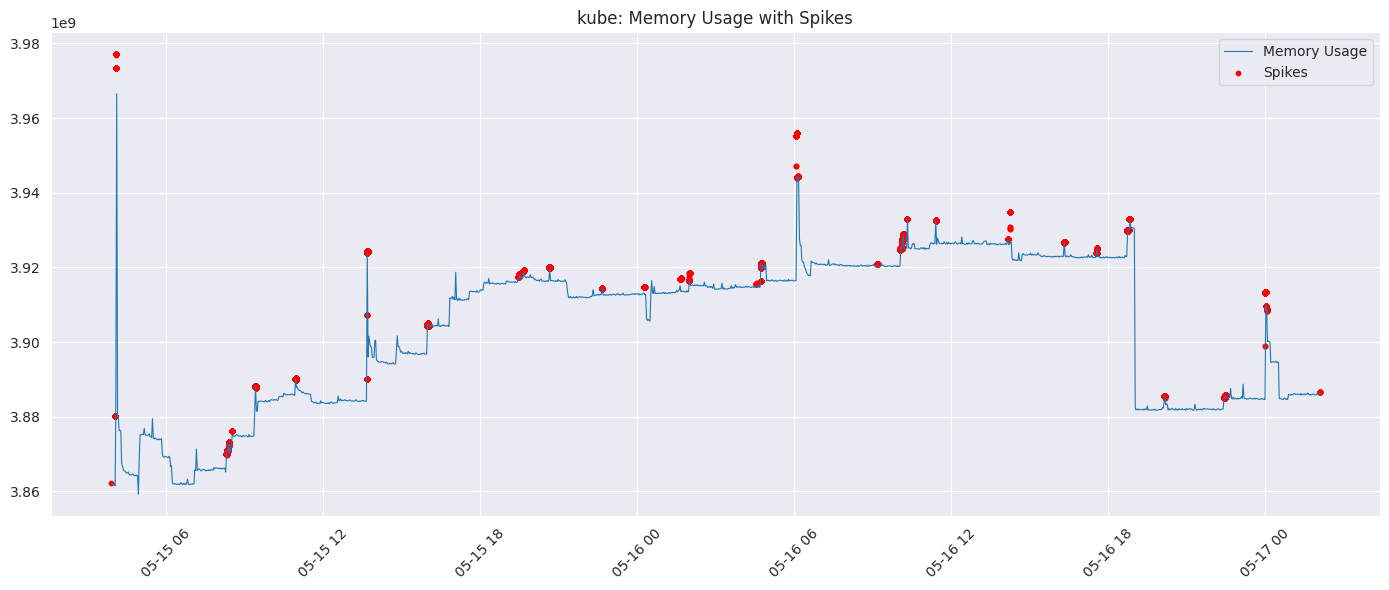

  Service  EventId  In High Std+Max  In Extreme (90%)  In Spike  \
0    kube       64             True              True      True   
1    kube       69             True              True      True   
2    kube       92             True              True      True   
3    kube       93             True              True      True   
4    kube       89             True              True      True   
5    kube       90             True              True      True   
6    kube       60             True              True      True   
7    kube       61             True              True      True   
8    kube       62             True              True      True   
9    kube       63             True              True      True   

                                     Example Content  
0  transport: loopyWriter.run returning. connecti...  
1  Trace[1787077587]: ---"About to write a respon...  
2  E0515 01:01:52.888423      18 controller.go:11...  
3  OpenAPI AggregationController: action f

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "kube"
structured_file = "kube-apiserver-ocp4-control-plane-1_messages_structured.csv"
templates_file = "kube-apiserver-ocp4-control-plane-1_messages_templates.csv"  # Optional: not used here
metric_file = "kube-apiserver-ocp4-control-plane-1.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 4 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)



In [26]:
print(comparison_df)

   Service  EventId  In High Std+Max  In Extreme (90%)  In Spike  \
0     kube       64             True              True      True   
1     kube      291             True              True      True   
2     kube       69             True              True      True   
3     kube       92             True              True      True   
4     kube       93             True              True      True   
5     kube       89             True              True      True   
6     kube       90             True              True      True   
7     kube       60             True              True      True   
8     kube       61             True              True      True   
9     kube       62             True              True      True   
10    kube       63             True              True      True   

                                      Example Content  
0   transport: loopyWriter.run returning. connecti...  
1   Trace[968877325]: [757.232779ms] [757.232779ms...  
2   Trace[17870

In [32]:
kube_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/kube_eventid_comparison_table.csv')
kube_eventid_comparison_table['Example Content'].tolist()

['transport: loopyWriter.run returning. connection error: desc = "transport is closing',
 'Trace[968877325]: [757.232779ms] [757.232779ms] END',
 'Trace[1787077587]: ---"About to write a response" 1844ms (02:34:00.688)',
 'E0515 01:01:52.888423      18 controller.go:116] loading OpenAPI spec for "v1beta1.metrics.k8s.io" failed with: OpenAPI spec does not exist',
 'OpenAPI AggregationController: action for item v1beta1.metrics.k8s.io: Rate Limited Requeue.',
 'Syncing configmaps: [{aggregator-client-ca false} {client-ca false} {trusted-ca-bundle true} {control-plane-node-kubeconfig false} {check-endpoints-ku',
 'Syncing secrets: [{aggregator-client false} {localhost-serving-cert-certkey false} {service-network-serving-certkey false} {external-loadbalancer-serv',
 'ClientConn switching balancer to "pick_first',
 'ccResolverWrapper: sending update to cc: {[{https://localhost:2379  <nil> 0 <nil>}] <nil> <nil>}',
 'parsed scheme: "passthrough',
 'pickfirstBalancer: HandleSubConnStateChange:

Unique EventIds in kube_plane2: 83


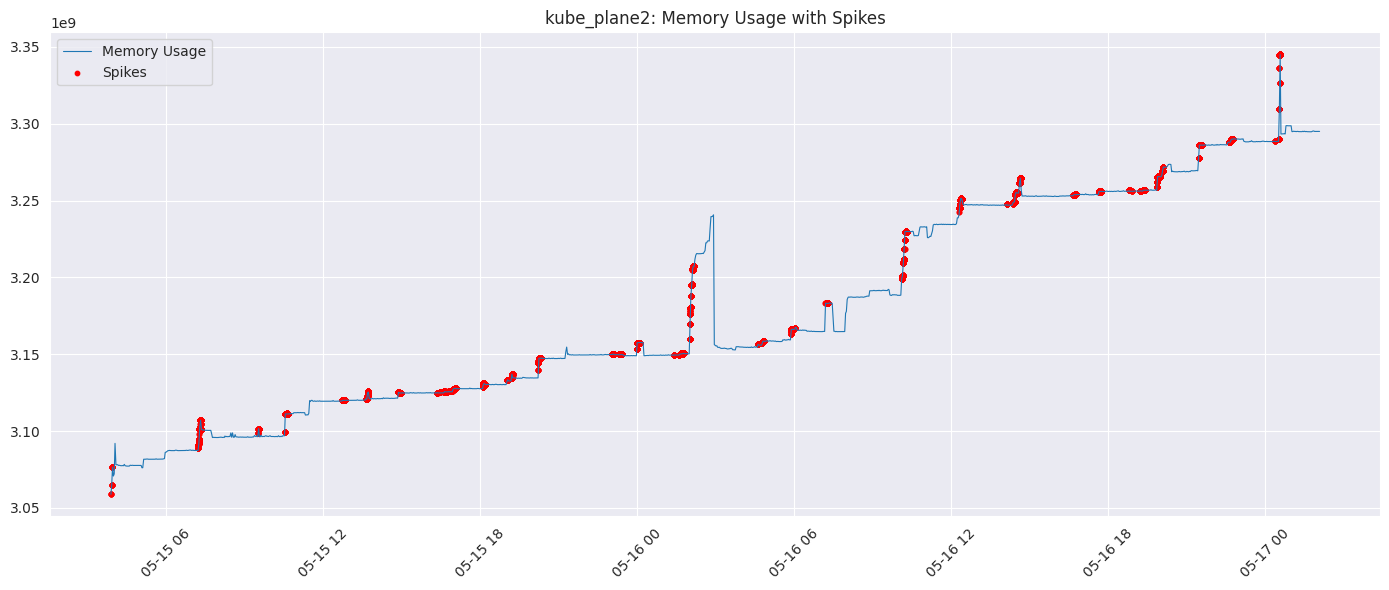

       Service  EventId  In High Std+Max  In Extreme (90%)  In Spike  \
0  kube_plane2       64             True              True      True   
1  kube_plane2       92             True              True      True   
2  kube_plane2       93             True              True      True   
3  kube_plane2       89             True              True      True   
4  kube_plane2       90             True              True      True   
5  kube_plane2       60             True              True      True   
6  kube_plane2       61             True              True      True   
7  kube_plane2       62             True              True      True   
8  kube_plane2       63             True              True      True   

                                     Example Content  
0  transport: loopyWriter.run returning. connecti...  
1  E0515 01:00:02.179270      18 controller.go:11...  
2  OpenAPI AggregationController: action for item...  
3  Syncing configmaps: [{aggregator-client-ca fal...  
4  S

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "kube_plane2"
structured_file = "kube-apiserver-ocp4-control-plane-2_messages_structured.csv"
templates_file = "kube-apiserver-ocp4-control-plane-2_messages_templates.csv"  # Optional: not used here
metric_file = "kube-apiserver-ocp4-control-plane-2.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)

In [41]:
print(comparison_df)

       Service  EventId  In High Std+Max  In Extreme (90%)  In Spike  \
0  kube_plane2       64             True              True      True   
1  kube_plane2       92             True              True      True   
2  kube_plane2       93             True              True      True   
3  kube_plane2       89             True              True      True   
4  kube_plane2       90             True              True      True   
5  kube_plane2       60             True              True      True   
6  kube_plane2       61             True              True      True   
7  kube_plane2       62             True              True      True   
8  kube_plane2       63             True              True      True   

                                     Example Content  
0  transport: loopyWriter.run returning. connecti...  
1  E0515 01:00:02.179270      18 controller.go:11...  
2  OpenAPI AggregationController: action for item...  
3  Syncing configmaps: [{aggregator-client-ca fal...  
4  S

In [42]:
kube_plane2_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/kube_plane2_eventid_comparison_table.csv')
kube_plane2_eventid_comparison_table['Example Content'].tolist()

['transport: loopyWriter.run returning. connection error: desc = "transport is closing',
 'E0515 01:00:02.179270      18 controller.go:116] loading OpenAPI spec for "v1beta1.metrics.k8s.io" failed with: OpenAPI spec does not exist',
 'OpenAPI AggregationController: action for item v1beta1.metrics.k8s.io: Rate Limited Requeue.',
 'Syncing configmaps: [{aggregator-client-ca false} {client-ca false} {trusted-ca-bundle true} {control-plane-node-kubeconfig false} {check-endpoints-ku',
 'Syncing secrets: [{aggregator-client false} {localhost-serving-cert-certkey false} {service-network-serving-certkey false} {external-loadbalancer-serv',
 'ClientConn switching balancer to "pick_first',
 'ccResolverWrapper: sending update to cc: {[{https://192.168.57.212:2379  <nil> 0 <nil>}] <nil> <nil>}',
 'parsed scheme: "passthrough',
 'pickfirstBalancer: HandleSubConnStateChange: 0xc026298600, {CONNECTING <nil>}']

Unique EventIds in kube_plane3: 1421


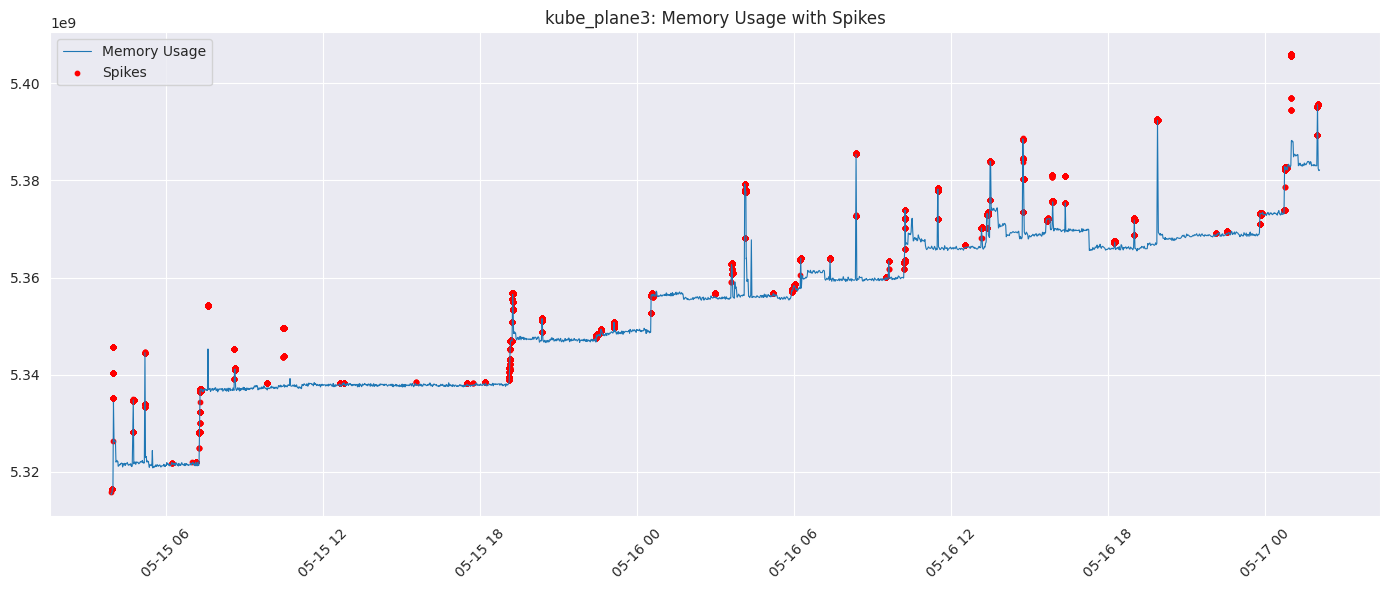

        Service  EventId  In High Std+Max  In Extreme (90%)  In Spike  \
0   kube_plane3       64             True              True      True   
1   kube_plane3       65             True              True      True   
2   kube_plane3       69             True              True      True   
3   kube_plane3      135             True              True      True   
4   kube_plane3      136             True              True      True   
5   kube_plane3      841             True              True      True   
6   kube_plane3      745             True              True      True   
7   kube_plane3      746             True              True      True   
8   kube_plane3       92             True              True      True   
9   kube_plane3       93             True              True      True   
10  kube_plane3       94             True              True      True   
11  kube_plane3       89             True              True      True   
12  kube_plane3       90             True          

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "kube_plane3"
structured_file = "kube-apiserver-ocp4-control-plane-3_messages_structured.csv"
templates_file = "kube-apiserver-ocp4-control-plane-3_messages_templates.csv"  # Optional: not used here
metric_file = "kube-apiserver-ocp4-control-plane-3.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)

In [44]:
print(comparison_df)

        Service  EventId  In High Std+Max  In Extreme (90%)  In Spike  \
0   kube_plane3       64             True              True      True   
1   kube_plane3       65             True              True      True   
2   kube_plane3       69             True              True      True   
3   kube_plane3      135             True              True      True   
4   kube_plane3      136             True              True      True   
5   kube_plane3      841             True              True      True   
6   kube_plane3      745             True              True      True   
7   kube_plane3      746             True              True      True   
8   kube_plane3       92             True              True      True   
9   kube_plane3       93             True              True      True   
10  kube_plane3       94             True              True      True   
11  kube_plane3       89             True              True      True   
12  kube_plane3       90             True          

In [45]:
kube_plane3_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/kube_plane3_eventid_comparison_table.csv')
kube_plane3_eventid_comparison_table['Example Content'].tolist()

['transport: loopyWriter.run returning. connection error: desc = "transport is closing',
 'Trace[688914234]: ---"Listing from storage done" 3137ms (02:34:00.260)',
 'Trace[1911379131]: ---"About to write a response" 2184ms (02:34:00.956)',
 'Trace[1960038243]: ---"Object stored in database" 6994ms (02:34:00.961)',
 'Trace[1929921131]: ---"Transaction committed" 1173ms (03:04:00.863)',
 'E0515 01:00:00.818046      19 fieldmanager.go:175] [SHOULD NOT HAPPEN] failed to update managedFields for /, Kind=: failed to convert new object (batc',
 'syncing external loadbalancer hostnames: api.lab.ocp.local',
 'syncing servicenetwork hostnames: [172.30.0.1 kubernetes kubernetes.default kubernetes.default.svc kubernetes.default.svc.cluster.local openshift open',
 'E0515 01:00:44.833370      19 controller.go:116] loading OpenAPI spec for "v1beta1.metrics.k8s.io" failed with: OpenAPI spec does not exist',
 'OpenAPI AggregationController: action for item v1beta1.metrics.k8s.io: Rate Limited Requeue.'

Unique EventIds in kube_controller_manager_plane1: 13


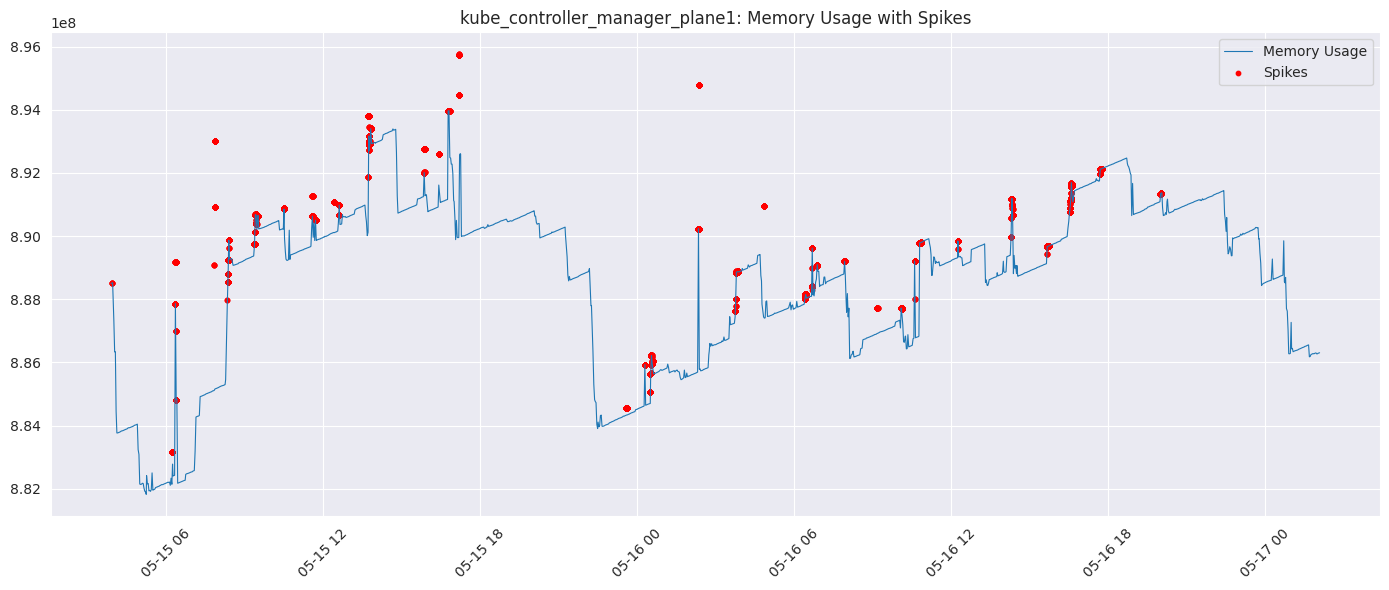

                           Service  EventId  In High Std+Max  \
0   kube_controller_manager_plane1      650             True   
1   kube_controller_manager_plane1      651             True   
2   kube_controller_manager_plane1      652             True   
3   kube_controller_manager_plane1      653             True   
4   kube_controller_manager_plane1      654             True   
5   kube_controller_manager_plane1      655             True   
6   kube_controller_manager_plane1      656             True   
7   kube_controller_manager_plane1      657             True   
8   kube_controller_manager_plane1      658             True   
9   kube_controller_manager_plane1      659             True   
10  kube_controller_manager_plane1      660             True   
11  kube_controller_manager_plane1      661             True   

    In Extreme (90%)  In Spike  \
0               True      True   
1               True      True   
2               True      True   
3               True      True 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "kube_controller_manager_plane1"
structured_file = "kube-controller-manager-ocp4-control-plane-1_messages_structured.csv"
templates_file = "kube-controller-manager-ocp4-control-plane-1_messages_templates.csv"  # Optional: not used here
metric_file = "kube-controller-manager-ocp4-control-plane-1.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)


In [3]:
print(comparison_df)

                           Service  EventId  In High Std+Max  \
0   kube_controller_manager_plane1      650             True   
1   kube_controller_manager_plane1      651             True   
2   kube_controller_manager_plane1      652             True   
3   kube_controller_manager_plane1      653             True   
4   kube_controller_manager_plane1      654             True   
5   kube_controller_manager_plane1      655             True   
6   kube_controller_manager_plane1      656             True   
7   kube_controller_manager_plane1      657             True   
8   kube_controller_manager_plane1      658             True   
9   kube_controller_manager_plane1      659             True   
10  kube_controller_manager_plane1      660             True   
11  kube_controller_manager_plane1      661             True   

    In Extreme (90%)  In Spike  \
0               True      True   
1               True      True   
2               True      True   
3               True      True 

In [4]:
kube_controller_plane1_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/kube_controller_manager_plane1_eventid_comparison_table.csv')
kube_controller_plane1_eventid_comparison_table['Example Content'].tolist()

['Syncing configmaps: [{aggregator-client-ca false} {client-ca false} {trusted-ca-bundle true}]',
 'Syncing secrets: [{kube-controller-manager-client-cert-key false} {csr-signer false}]',
 '"Event occurred" object="openshift-logging/elasticsearch-im-app" kind="CronJob" apiVersion="batch/v1beta1" type="Normal" reason="SuccessfulCreate" mes',
 'Unable to update status for openshift-logging/elasticsearch-im-app (rv = 94697601): Operation cannot be fulfilled on cronjobs.batch "elasticsearch-im-',
 '"Event occurred" object="openshift-logging/elasticsearch-im-audit-1621040400" kind="Job" apiVersion="batch/v1" type="Normal" reason="Completed" messag',
 '"Event occurred" object="openshift-logging/elasticsearch-im-app" kind="CronJob" apiVersion="batch/v1beta1" type="Normal" reason="SawCompletedJob" mess',
 '"Event occurred" object="openshift-logging/elasticsearch-im-app" kind="CronJob" apiVersion="batch/v1beta1" type="Normal" reason="SuccessfulDelete" mes',
 '"Processing object" object="openshi

## etcd

Unique EventIds in etcd-ocp4-control-plane-1: 30


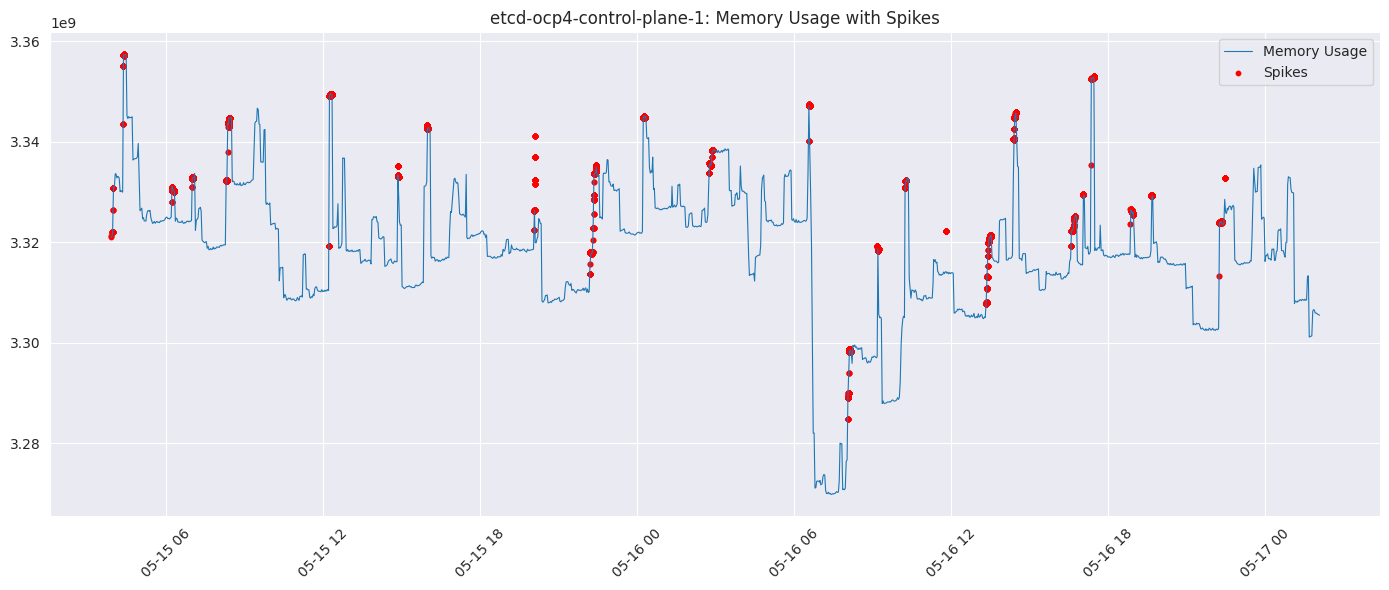

                      Service  EventId  In High Std+Max  In Extreme (90%)  \
0   etcd-ocp4-control-plane-1       18             True              True   
1   etcd-ocp4-control-plane-1       19             True              True   
2   etcd-ocp4-control-plane-1       20             True              True   
3   etcd-ocp4-control-plane-1       21             True              True   
4   etcd-ocp4-control-plane-1       22             True              True   
5   etcd-ocp4-control-plane-1       23             True              True   
6   etcd-ocp4-control-plane-1       24             True              True   
7   etcd-ocp4-control-plane-1       25             True              True   
8   etcd-ocp4-control-plane-1       26             True              True   
9   etcd-ocp4-control-plane-1       27             True              True   
10  etcd-ocp4-control-plane-1       28             True              True   
11  etcd-ocp4-control-plane-1       29             True              True   

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "etcd-ocp4-control-plane-1"
structured_file = "etcd-ocp4-control-plane-1_messages_structured.csv"
templates_file = "etcd-ocp4-control-plane-1_messages_templates.csv"  # Optional: not used here
metric_file = "etcd-ocp4-control-plane-1.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)

In [6]:
print(comparison_df)

                      Service  EventId  In High Std+Max  In Extreme (90%)  \
0   etcd-ocp4-control-plane-1       18             True              True   
1   etcd-ocp4-control-plane-1       19             True              True   
2   etcd-ocp4-control-plane-1       20             True              True   
3   etcd-ocp4-control-plane-1       21             True              True   
4   etcd-ocp4-control-plane-1       22             True              True   
5   etcd-ocp4-control-plane-1       23             True              True   
6   etcd-ocp4-control-plane-1       24             True              True   
7   etcd-ocp4-control-plane-1       25             True              True   
8   etcd-ocp4-control-plane-1       26             True              True   
9   etcd-ocp4-control-plane-1       27             True              True   
10  etcd-ocp4-control-plane-1       28             True              True   
11  etcd-ocp4-control-plane-1       29             True              True   

In [7]:
etcd_plane1_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/etcd-ocp4-control-plane-1_eventid_comparison_table.csv')
etcd_plane1_eventid_comparison_table['Example Content'].tolist()

['.169432 I | embed: rejected connection from "192.168.57.211:45796" (error "EOF", ServerName "")',
 '.016709 I | etcdserver/api/etcdhttp: /health OK (status code 200)',
 '.001721 I | mvcc: store.index: compact 94704629',
 '.123312 I | mvcc: finished scheduled compaction at 94704629 (took 117.351632ms)',
 '.968316 I | embed: rejected connection from "192.168.57.210:48666" (error "read tcp 192.168.57.211:2380->192.168.57.210:48666: read: connection reset ',
 '.487550 I | wal: segmented wal file /var/lib/etcd/member/wal/0000000000004a0f-000000000dc6ba9c.wal is created',
 '.104342 I | pkg/fileutil: purged file /var/lib/etcd/member/wal/0000000000004a09-000000000dc5b46d.wal successfully',
 '.966919 W | rafthttp: rejected the stream from peer 6a47cc374b1c53d0 since it was removed',
 '.494595 I | etcdserver: start to snapshot (applied: 231202476, lastsnap: 231102475)',
 '.500451 I | etcdserver: saved snapshot at index 231202476',
 '.500792 I | etcdserver: compacted raft log at 231197476',
 '.

Unique EventIds in etcd-ocp4-control-plane-2: 25


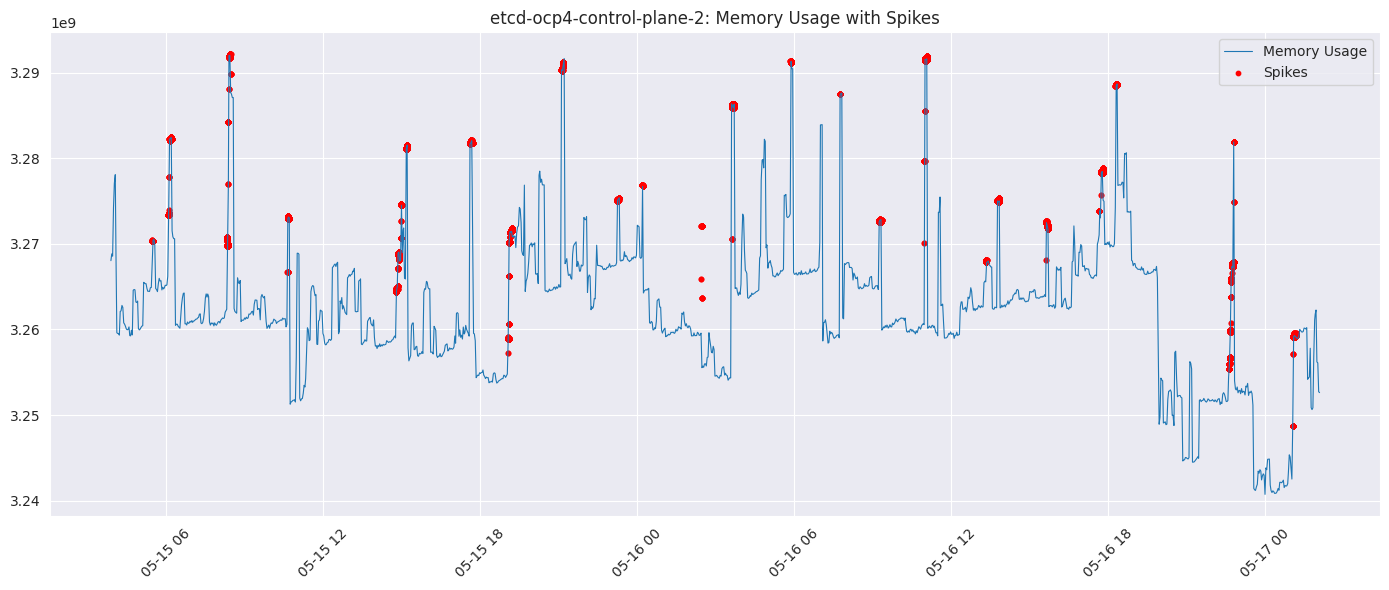

                      Service  EventId  In High Std+Max  In Extreme (90%)  \
0   etcd-ocp4-control-plane-2       32             True              True   
1   etcd-ocp4-control-plane-2       18             True              True   
2   etcd-ocp4-control-plane-2       19             True              True   
3   etcd-ocp4-control-plane-2       20             True              True   
4   etcd-ocp4-control-plane-2       21             True              True   
5   etcd-ocp4-control-plane-2       22             True              True   
6   etcd-ocp4-control-plane-2       23             True              True   
7   etcd-ocp4-control-plane-2       24             True              True   
8   etcd-ocp4-control-plane-2       26             True              True   
9   etcd-ocp4-control-plane-2       27             True              True   
10  etcd-ocp4-control-plane-2       28             True              True   
11  etcd-ocp4-control-plane-2       29             True              True   

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "etcd-ocp4-control-plane-2"
structured_file = "etcd-ocp4-control-plane-2_messages_structured.csv"
templates_file = "etcd-ocp4-control-plane-2_messages_templates.csv"  # Optional: not used here
metric_file = "etcd-ocp4-control-plane-2.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)

In [11]:
print(comparison_df)

                      Service  EventId  In High Std+Max  In Extreme (90%)  \
0   etcd-ocp4-control-plane-2       32             True              True   
1   etcd-ocp4-control-plane-2       18             True              True   
2   etcd-ocp4-control-plane-2       19             True              True   
3   etcd-ocp4-control-plane-2       20             True              True   
4   etcd-ocp4-control-plane-2       21             True              True   
5   etcd-ocp4-control-plane-2       22             True              True   
6   etcd-ocp4-control-plane-2       23             True              True   
7   etcd-ocp4-control-plane-2       24             True              True   
8   etcd-ocp4-control-plane-2       26             True              True   
9   etcd-ocp4-control-plane-2       27             True              True   
10  etcd-ocp4-control-plane-2       28             True              True   
11  etcd-ocp4-control-plane-2       29             True              True   

In [12]:
etcd_plane2_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/etcd-ocp4-control-plane-2_eventid_comparison_table.csv')
etcd_plane2_eventid_comparison_table['Example Content'].tolist()

['.685938 W | wal: sync duration of 1.452781383s, expected less than 1s',
 '.078101 I | embed: rejected connection from "192.168.57.212:52886" (error "EOF", ServerName "")',
 '.732406 I | etcdserver/api/etcdhttp: /health OK (status code 200)',
 '.002207 I | mvcc: store.index: compact 94704629',
 '.132465 I | mvcc: finished scheduled compaction at 94704629 (took 124.645653ms)',
 '.998429 I | embed: rejected connection from "192.168.57.210:52418" (error "read tcp 192.168.57.212:2380->192.168.57.210:52418: read: connection reset ',
 '.449555 I | wal: segmented wal file /var/lib/etcd/member/wal/0000000000004a0e-000000000dc6911f.wal is created',
 '.575443 I | pkg/fileutil: purged file /var/lib/etcd/member/wal/0000000000004a09-000000000dc5b725.wal successfully',
 '.450469 I | etcdserver: start to snapshot (applied: 231202474, lastsnap: 231102473)',
 '.457916 I | etcdserver: saved snapshot at index 231202474',
 '.458451 I | etcdserver: compacted raft log at 231197474',
 '.221490 W | etcdserve

Unique EventIds in etcd-ocp4-control-plane-3: 27


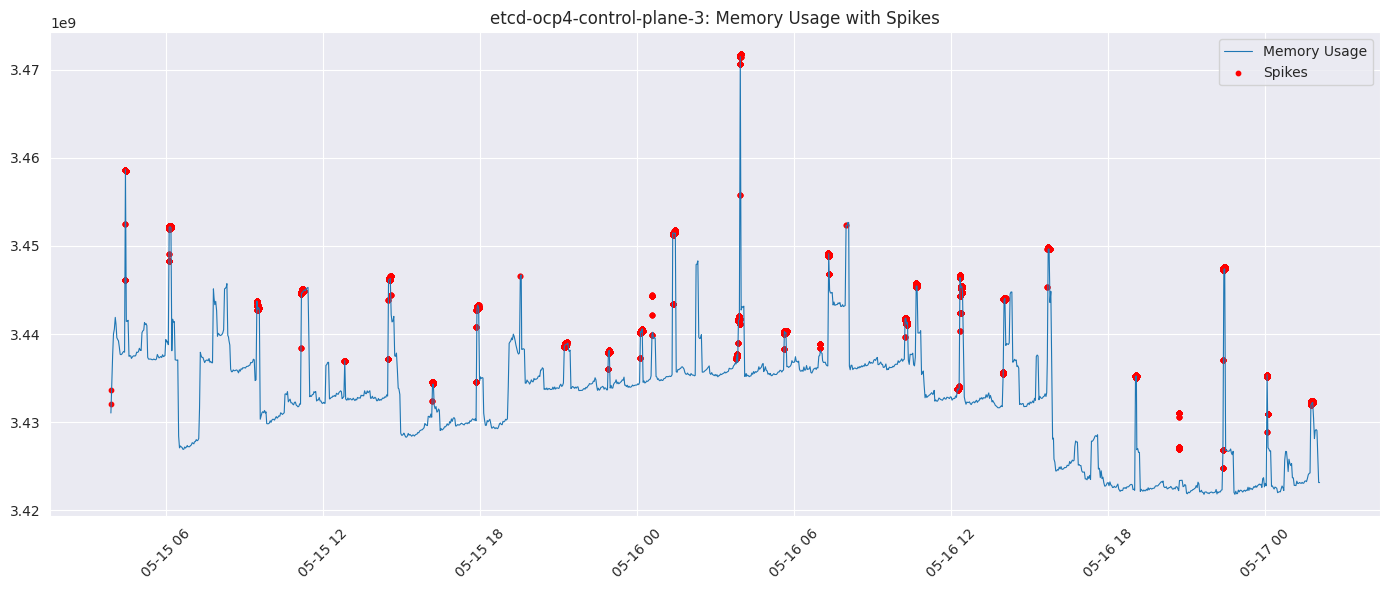

                     Service  EventId  In High Std+Max  In Extreme (90%)  \
0  etcd-ocp4-control-plane-3       18             True              True   
1  etcd-ocp4-control-plane-3       19             True              True   
2  etcd-ocp4-control-plane-3       20             True              True   
3  etcd-ocp4-control-plane-3       21             True              True   
4  etcd-ocp4-control-plane-3       23             True              True   
5  etcd-ocp4-control-plane-3       26             True              True   
6  etcd-ocp4-control-plane-3       27             True              True   
7  etcd-ocp4-control-plane-3       28             True              True   
8  etcd-ocp4-control-plane-3       30             True              True   
9  etcd-ocp4-control-plane-3       31             True              True   

   In Spike                                    Example Content  
0      True  .684015 I | embed: rejected connection from "1...  
1      True  .787244 I | etcdserv

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "etcd-ocp4-control-plane-3"
structured_file = "etcd-ocp4-control-plane-3_messages_structured.csv"
templates_file = "etcd-ocp4-control-plane-3_messages_templates.csv"  # Optional: not used here
metric_file = "etcd-ocp4-control-plane-3.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)

In [14]:
print(comparison_df)

                     Service  EventId  In High Std+Max  In Extreme (90%)  \
0  etcd-ocp4-control-plane-3       18             True              True   
1  etcd-ocp4-control-plane-3       19             True              True   
2  etcd-ocp4-control-plane-3       20             True              True   
3  etcd-ocp4-control-plane-3       21             True              True   
4  etcd-ocp4-control-plane-3       23             True              True   
5  etcd-ocp4-control-plane-3       26             True              True   
6  etcd-ocp4-control-plane-3       27             True              True   
7  etcd-ocp4-control-plane-3       28             True              True   
8  etcd-ocp4-control-plane-3       30             True              True   
9  etcd-ocp4-control-plane-3       31             True              True   

   In Spike                                    Example Content  
0      True  .684015 I | embed: rejected connection from "1...  
1      True  .787244 I | etcdserv

In [15]:
etcd_plane3_eventid_comparison_table = pd.read_csv('/home/alona/alona/McS/Applied_Data_Science/Thesis/Code/pythonProject/etcd-ocp4-control-plane-3_eventid_comparison_table.csv')
etcd_plane3_eventid_comparison_table['Example Content'].tolist()

['.684015 I | embed: rejected connection from "192.168.57.213:59924" (error "EOF", ServerName "")',
 '.787244 I | etcdserver/api/etcdhttp: /health OK (status code 200)',
 '.001642 I | mvcc: store.index: compact 94704629',
 '.123926 I | mvcc: finished scheduled compaction at 94704629 (took 118.121319ms)',
 '.099915 I | wal: segmented wal file /var/lib/etcd/member/wal/0000000000004a07-000000000dc6a98b.wal is created',
 '.697246 I | etcdserver: start to snapshot (applied: 231202525, lastsnap: 231102524)',
 '.703117 I | etcdserver: saved snapshot at index 231202525',
 '.703554 I | etcdserver: compacted raft log at 231197525',
 '.230636 W | etcdserver: read-only range request "key:\\"/kubernetes.io/noobaa.io/noobaas/\\" range_end:\\"/kubernetes.io/noobaa.io/noobaas0\\" count_only:',
 '.231064 W | etcdserver: read-only range request "key:\\"/kubernetes.io/pods/openshift-apiserver/\\" range_end:\\"/kubernetes.io/pods/openshift-apiserver0']

## productpage (jaeger not focusing - not enough unique templates)

Unique EventIds in productpage: 11


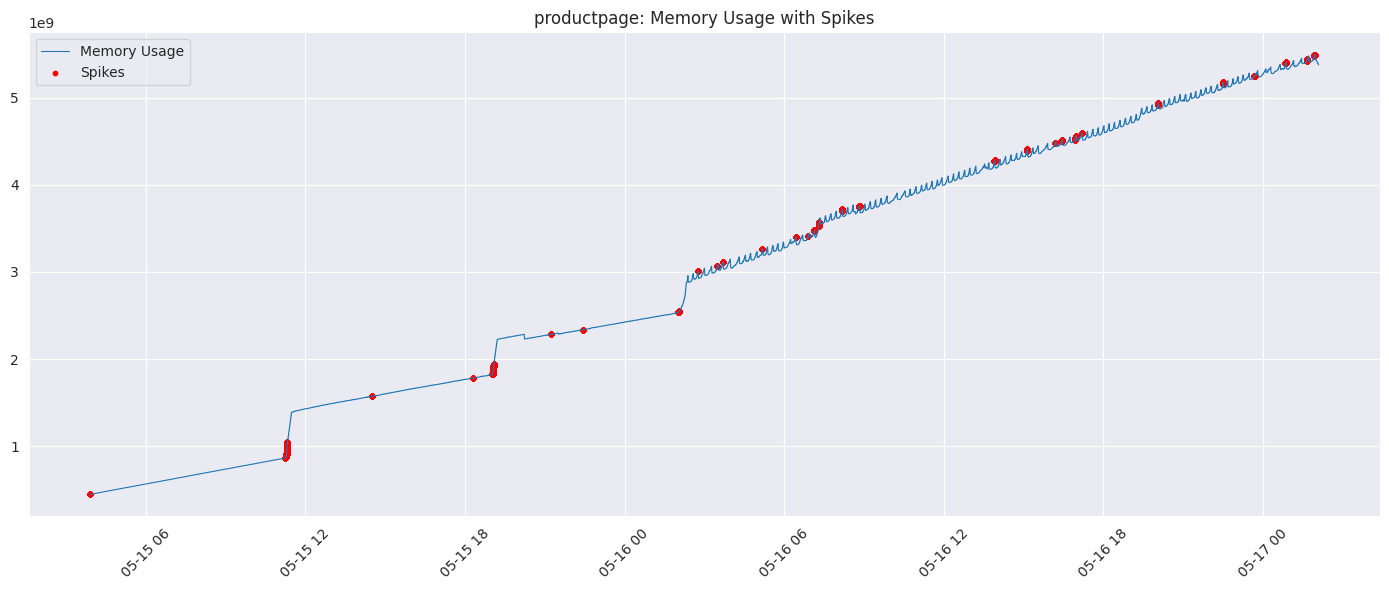

KeyboardInterrupt: 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
path_logs = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Log_data/20210517/pod_removed')
path_metrics = Path('/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Metric_data/20210517/flattened_pods/product')

# === MANUAL FILE SELECTION ===
service_name = "productpage"
structured_file = "productpage-v1-6687ddf68f-pbdzm_messages_structured.csv"
templates_file = "productpage-v1-6687ddf68f-pbdzm_messages_templates.csv"  # Optional: not used here
metric_file = "productpage-v1-6687ddf68f-pbdzm.csv"  

# --- LOAD DATA ---
log_df = pd.read_csv(path_logs / structured_file)
metric_df = pd.read_csv(path_metrics / metric_file)

log_df['Time'] = pd.to_datetime(log_df['Time']).dt.tz_localize(None).dt.floor('s')
metric_df['timestamp'] = pd.to_datetime(metric_df['timestamp']).dt.floor('s')

merged_df = pd.merge(log_df, metric_df, left_on='Time', right_on='timestamp', how='inner').drop(columns='timestamp')

# === ANALYSIS FUNCTIONS ===

def compute_eventid_stats(df):
    stats = df.groupby('EventId').agg({
        'cpu_usage': ['mean', 'median', 'max', 'std'],
        'memory_usage': ['mean', 'median', 'max', 'std']
    }).reset_index()
    stats.columns = ['EventId', 'cpu_mean', 'cpu_median', 'cpu_max', 'cpu_std',
                     'memory_mean', 'memory_median', 'memory_max', 'memory_std']
    return stats

def detect_memory_spikes(df):
    df = df.sort_values('Time')
    df['memory_rolling_mean'] = df['memory_usage'].rolling(window=24*3600, min_periods=1).mean()
    df['memory_rolling_std'] = df['memory_usage'].rolling(window=24*3600, min_periods=1).std()
    df['memory_spike'] = (df['memory_usage'] - df['memory_rolling_mean'] > 3 * df['memory_rolling_std']).astype(int)
    return df.drop(columns=['memory_rolling_mean', 'memory_rolling_std'])

def extract_preceding_logs(df, col='memory_spike', window_s=60):
    window = pd.Timedelta(seconds=window_s)
    logs = []
    for _, row in df[df[col] == 1].iterrows():
        t = row['Time']
        logs.append(df[(df['Time'] < t) & (df['Time'] >= t - window)])
    return pd.concat(logs, ignore_index=True) if logs else pd.DataFrame()

def generate_eventid_comparison_table(service, stats, merged, original):
    top_ids = set(stats.sort_values('memory_std', ascending=False).head(10)['EventId']) | \
              set(stats.sort_values('memory_max', ascending=False).head(10)['EventId'])

    extreme_ids = set(merged[merged['memory_usage'] > merged['memory_usage'].quantile(0.9)]['EventId'].dropna())

    merged = detect_memory_spikes(merged)
    spike_logs = extract_preceding_logs(merged, 'memory_spike')
    spike_ids = set(spike_logs['EventId'].dropna())

    # EventIds present in all three
    all_ids = top_ids & extreme_ids & spike_ids

    rows = []
    for eid in all_ids:
        content = original[original['EventId'] == eid]['Content'].dropna().unique()
        rows.append({
            'Service': service,
            'EventId': eid,
            'In High Std+Max': True,
            'In Extreme (90%)': True,
            'In Spike': True,
            'Example Content': content[0][:150] if len(content) else ''
        })

    return pd.DataFrame(rows)

def plot_memory_with_spikes(df):
    spikes = df[df['memory_spike'] == 1]
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'].values[::100], df['memory_usage'].values[::100], label='Memory Usage', linewidth=0.8)
    plt.scatter(spikes['Time'], spikes['memory_usage'], color='red', label='Spikes', s=10)
    plt.legend()
    plt.title(f"{service_name}: Memory Usage with Spikes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === RUN PIPELINE ===
print(f"Unique EventIds in {service_name}: {merged_df['EventId'].nunique()}")
stats = compute_eventid_stats(merged_df)
merged_df = detect_memory_spikes(merged_df)
plot_memory_with_spikes(merged_df)
comparison_df = generate_eventid_comparison_table(service_name, stats, merged_df, log_df)
comparison_df.to_csv(f"{service_name}_eventid_comparison_table.csv", index=False)
print(comparison_df)

In [23]:
print(comparison_df)

                     Service  EventId  In High Std+Max  In Extreme (90%)  \
0  etcd-ocp4-control-plane-3       18             True              True   
1  etcd-ocp4-control-plane-3       19             True              True   
2  etcd-ocp4-control-plane-3       20             True              True   
3  etcd-ocp4-control-plane-3       21             True              True   
4  etcd-ocp4-control-plane-3       23             True              True   
5  etcd-ocp4-control-plane-3       26             True              True   
6  etcd-ocp4-control-plane-3       27             True              True   
7  etcd-ocp4-control-plane-3       28             True              True   
8  etcd-ocp4-control-plane-3       30             True              True   
9  etcd-ocp4-control-plane-3       31             True              True   

   In Spike                                    Example Content  
0      True  .684015 I | embed: rejected connection from "1...  
1      True  .787244 I | etcdserv

# Microservices with highest memory values 

In [ ]:
base_model_logs = Path("/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Merged_data/20210517/pods_product")
base_model = Path("/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Merged_data/20210517/pods_product/Model")

In [10]:
for file in base_model_logs.glob("*.parquet"):
    df = pd.read_parquet(file)
df

,LineId,Time,Content,EventId,EventTemplate,ParameterList,timestamp,latency,cpu_usage,memory_usage,rate_received_packets,rate_transmitted_packets,received_bandwidth,transmit_bandwidth,label
0,55,2021-05-15 04:17:17,info\tSubchannel Connectivity change to CONNEC...,46,info <*> Connectivity change to <*>,"['Subchannel', 'CONNECTING']",2021-05-15 04:17:17,60.062500,0.006184,276910080.0,6.638981,4.954141,720.174026,3969.906942,Book_Info_product
1,56,2021-05-15 04:17:17,info\ttransport: loopyWriter.run returning. co...,47,info transport: loopyWriter.run returning. con...,[],2021-05-15 04:17:17,60.062500,0.006184,276910080.0,6.638981,4.954141,720.174026,3969.906942,Book_Info_product
2,57,2021-05-15 04:17:17,info\tpickfirstBalancer: HandleSubConnStateCha...,48,info pickfirstBalancer: HandleSubConnStateChan...,['{CONNECTING'],2021-05-15 04:17:17,60.062500,0.006184,276910080.0,6.638981,4.954141,720.174026,3969.906942,Book_Info_product
3,58,2021-05-15 04:17:17,info\tChannel Connectivity change to CONNECTING,46,info <*> Connectivity change to <*>,"['Channel', 'CONNECTING']",2021-05-15 04:17:17,60.062500,0.006184,276910080.0,6.638981,4.954141,720.174026,3969.906942,Book_Info_product
4,59,2021-05-15 04:17:17,"info\tSubchannel picks a new address ""istiod-b...",49,"info Subchannel picks a new address ""istiod-ba...",[],2021-05-15 04:17:17,60.062500,0.006184,276910080.0,6.638981,4.954141,720.174026,3969.906942,Book_Info_product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,906,2021-05-17 01:36:16,info\tpickfirstBalancer: HandleSubConnStateCha...,48,info pickfirstBalancer: HandleSubConnStateChan...,['{CONNECTING'],2021-05-17 01:36:16,24536.571429,0.006671,262672384.0,6.421190,5.005871,703.070131,6518.880168,Book_Info_product
852,907,2021-05-17 01:36:16,info\tChannel Connectivity change to CONNECTING,46,info <*> Connectivity change to <*>,"['Channel', 'CONNECTING']",2021-05-17 01:36:16,24536.571429,0.006671,262672384.0,6.421190,5.005871,703.070131,6518.880168,Book_Info_product
853,908,2021-05-17 01:36:16,info\tSubchannel Connectivity change to READY,46,info <*> Connectivity change to <*>,"['Subchannel', 'READY']",2021-05-17 01:36:16,24536.571429,0.006671,262672384.0,6.421190,5.005871,703.070131,6518.880168,Book_Info_product
854,909,2021-05-17 01:36:16,info\tpickfirstBalancer: HandleSubConnStateCha...,48,info pickfirstBalancer: HandleSubConnStateChan...,['{READY'],2021-05-17 01:36:16,24536.571429,0.006671,262672384.0,6.421190,5.005871,703.070131,6518.880168,Book_Info_product


In [5]:
all_dfs = []

# Iterate through all parquet files
for file in base_model_logs.glob('*.parquet'):
    df = pd.read_parquet(file)

    # Get service name from file name
    service_name = file.stem  # e.g., 'jaeger-query'
    service_type = service_name.split('-')[0]  # Extract 'jaeger' from 'jaeger-query'

    # Add service_type as a column
    df['service_type'] = service_type

    # Keep only relevant columns
    df = df[['Time', 'EventTemplate', 'EventId', 'ParameterList', 'cpu_usage', 'memory_usage', 'service_type']]

    all_dfs.append(df)

# Merge all dataframes
merged_df = pd.concat(all_dfs, ignore_index=True)

# Optional: convert Time to datetime and create time_bin column
#merged_df['Time'] = pd.to_datetime(merged_df['Time'])
#merged_df['time_bin'] = merged_df['Time'].dt.floor('10s')

# Final column order
merged_df = merged_df[['Time', 'service_type', 'EventTemplate', 'EventId', 'ParameterList', 'cpu_usage', 'memory_usage']]


/tmp/ipykernel_13244/2781315700.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(all_dfs, ignore_index=True)


In [3]:
# Create "Logs" subfolder if it doesn't exist
logs_path = base_model_logs / "Logs"
logs_path.mkdir(parents=True, exist_ok=True)

# Save the merged DataFrame
output_file = logs_path / "merged_df.parquet"

merged_df.to_parquet(output_file, index=False)

NameError: name 'merged_df' is not defined

In [9]:
grouped_df = merged_df.groupby(['Time', 'service_type']).agg({
    'cpu_usage': 'max',
    'memory_usage': 'max',
    'EventTemplate': 'count'  # or use 'nunique' to count distinct templates
}).reset_index().rename(columns={'EventTemplate': 'log_count'})

# Save the merged DataFrame
output_file = logs_path / "grouped_df.parquet"

grouped_df.to_parquet(output_file, index=False)

## Exploring logs preceding spikes in memory and cpu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base_model_logs = Path("/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Merged_data/20210517/pods_product")
logs_path = base_model_logs / "Logs"

In [3]:
grouped_df = pd.read_parquet(logs_path / "grouped_df.parquet")
grouped_df

,Time,service_type,cpu_usage,memory_usage,log_count
0,2021-05-15 03:53:56,details,0.094531,2.328125e+08,68
1,2021-05-15 03:53:56,jaeger,0.069964,3.381854e+09,298
2,2021-05-15 03:53:56,kafka,0.006915,8.056832e+08,1
3,2021-05-15 03:53:56,kube,0.469780,5.315547e+09,2
4,2021-05-15 03:53:56,my,0.007146,8.143053e+08,1
...,...,...,...,...,...
1463120,2021-05-17 02:05:59,etcd,0.126051,3.252630e+09,2
1463121,2021-05-17 02:05:59,jaeger,0.059411,2.415546e+09,156
1463122,2021-05-17 02:05:59,kube,0.133308,3.295281e+09,7
1463123,2021-05-17 02:05:59,my,0.007246,8.478925e+08,1


In [8]:
grouped_df = grouped_df.rename(columns={
    'cpu_usage': 'cpu_usage_max',
    'memory_usage': 'memory_usage_max'
})
grouped_df

,Time,service_type,cpu_usage_max,memory_usage_max,log_count
0,2021-05-15 03:53:56,details,0.094531,2.328125e+08,68
1,2021-05-15 03:53:56,jaeger,0.069964,3.381854e+09,298
2,2021-05-15 03:53:56,kafka,0.006915,8.056832e+08,1
3,2021-05-15 03:53:56,kube,0.469780,5.315547e+09,2
4,2021-05-15 03:53:56,my,0.007146,8.143053e+08,1
...,...,...,...,...,...
1463120,2021-05-17 02:05:59,etcd,0.126051,3.252630e+09,2
1463121,2021-05-17 02:05:59,jaeger,0.059411,2.415546e+09,156
1463122,2021-05-17 02:05:59,kube,0.133308,3.295281e+09,7
1463123,2021-05-17 02:05:59,my,0.007246,8.478925e+08,1


## Which  services consume the most CPU or memory? Is high CPU/memory associated with high log count?

In [9]:
service_stats = grouped_df.groupby("service_type").agg({
    "cpu_usage_max": "mean",
    "memory_usage_max": "mean",
    "log_count": "mean"
}).sort_values("cpu_usage_max", ascending=False)

print("Top services by CPU usage:")
print(service_stats["cpu_usage_max"].sort_values(ascending=False).head(10))

print("\nTop services by memory usage:")
print(service_stats["memory_usage_max"].sort_values(ascending=False).head(10))


Top services by CPU usage:
service_type
catalogue         4.910347
reviews           1.294545
productpage       0.552941
kube              0.275668
etcd              0.158479
elasticsearch     0.116048
jaeger            0.073204
details           0.065156
authentication    0.038805
prometheus        0.028393
Name: cpu_usage_max, dtype: float64

Top services by memory usage:
service_type
kube           3.536665e+09
etcd           3.353663e+09
jaeger         3.117017e+09
productpage    2.921705e+09
amq            1.510140e+09
reviews        1.353949e+09
shipping       1.084294e+09
my             8.188146e+08
kafka          8.071836e+08
olm            7.656587e+08
Name: memory_usage_max, dtype: float64


 ## Interpretation:

    - catalogue is a clear outlier, using 4.91 CPU units — this suggests heavy computation or inefficient processing.

    - reviews and productpage are known Istio demo app services — moderately intensive.

    - System services (kube, etcd, jaeger) show consistent, moderate usage — likely due to background orchestration or telemetry.

## Interpretation:

    - Core system services (kube, etcd, jaeger) consume the most memory — consistent with their role in orchestration and observability.

    - App-layer services (productpage, amq, reviews) also show significant memory allocation — worth profiling during peak load.

    - my and olm are lighter, possibly supporting or sidecar containers

## Preceding logs to high cpu or memory

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base_model_logs = Path("/home/alona/alona/McS/Applied_Data_Science/Thesis/Dataset/Product_review_preprocessed/Merged_data/20210517/pods_product")
logs_path = base_model_logs / "Logs"

In [4]:
merged_full = pd.read_parquet(logs_path / "merged_full.parquet")
merged_full

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count
0,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0,0.004108,37638144.0,4
1,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0,0.004108,37638144.0,4
2,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0,0.004108,37638144.0,4
3,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0,0.004108,37638144.0,4
4,2021-05-15 03:55:39,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:55:39.875Z|104013|reconnect|WA...,0.004093,37638144.0,0.004093,37638144.0,4
...,...,...,...,...,...,...,...,...,...,...
77888954,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{CONNECTING'],0.006671,262672384.0,0.006671,262672384.0,8
77888955,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Channel', 'CONNECTING']",0.006671,262672384.0,0.006671,262672384.0,8
77888956,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Subchannel', 'READY']",0.006671,262672384.0,0.006671,262672384.0,8
77888957,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{READY'],0.006671,262672384.0,0.006671,262672384.0,8


In [5]:
high_mem_thresh = merged_full.groupby("service_type")["memory_usage_raw"].transform(lambda x: x.quantile(0.90))
high_cpu_thresh = merged_full.groupby("service_type")["cpu_usage_raw"].transform(lambda x: x.quantile(0.90))

merged_full["high_memory"] = merged_full["memory_usage_raw"] > high_mem_thresh
merged_full["high_cpu"] = merged_full["cpu_usage_raw"] > high_cpu_thresh


In [32]:
# Count balance for high memory usage
memory_balance = merged_full['high_memory'].value_counts()
print("High Memory Usage Class Balance:")
print(memory_balance)

# Count balance for high CPU usage
cpu_balance = merged_full['high_cpu'].value_counts()
print("\nHigh CPU Usage Class Balance:")
print(cpu_balance)


High Memory Usage Class Balance:
high_memory
False    70155504
True      7733455
Name: count, dtype: int64

High CPU Usage Class Balance:
high_cpu
False    70111144
True      7777815
Name: count, dtype: int64


### Group logs by service and time, and use a rolling time window (e.g., 30s, 60s) before a high usage point:

In [6]:
merged_full['Time'] = pd.to_datetime(merged_full['Time'])
merged_full = merged_full.sort_values(['service_type', 'Time'])

# Create lag features: was a high memory usage in the next 30s?
merged_full['future_high_mem'] = merged_full.groupby('service_type')['high_memory'].shift(-1)

In [7]:
merged_full

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count,high_memory,high_cpu,future_high_mem
23955282,2021-05-15 03:54:30,amq,INFO ClusterOperator:125 - Triggering periodic...,437,[],0.007751,1.509925e+09,0.007751,1.509925e+09,2,False,False,False
23955283,2021-05-15 03:54:30,amq,INFO AbstractOperator:254 - Reconciliation <*>...,438,['#2523(timer)'],0.007751,1.509925e+09,0.007751,1.509925e+09,2,False,False,False
23955284,2021-05-15 03:54:34,amq,INFO AbstractOperator:493 - Reconciliation <*>...,439,['#2523(timer)'],0.007751,1.509925e+09,0.007751,1.509925e+09,1,False,False,False
23955285,2021-05-15 03:56:30,amq,INFO ClusterOperator:125 - Triggering periodic...,437,[],0.007691,1.509925e+09,0.007691,1.509925e+09,2,False,False,False
23955286,2021-05-15 03:56:30,amq,INFO AbstractOperator:254 - Reconciliation <*>...,438,['#2524(timer)'],0.007691,1.509925e+09,0.007691,1.509925e+09,2,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194000,2021-05-17 01:38:38,web,info transport: loopyWriter.run returning. con...,47,[],0.003478,1.331405e+08,0.003478,1.331405e+08,8,True,False,True
37194001,2021-05-17 01:38:38,web,info <*> Connectivity change to <*>,46,"['Subchannel', 'READY']",0.003478,1.331405e+08,0.003478,1.331405e+08,8,True,False,True
37194002,2021-05-17 01:38:38,web,info <*> Connectivity change to <*>,46,"['Channel', 'READY']",0.003478,1.331405e+08,0.003478,1.331405e+08,8,True,False,True
37194003,2021-05-17 01:38:38,web,info pickfirstBalancer: HandleSubConnStateChan...,48,"['0xc000615a40,', '{READY']",0.003478,1.331405e+08,0.003478,1.331405e+08,8,True,False,True


## Just for the services kube, jaeger or etcd

In [35]:
merged_full_filtered = merged_full[merged_full['service_type'].isin(['etcd'])] #'jaeger', 'kube

In [28]:
merged_full_filtered #kube, jaeger, etcd

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count,high_memory,high_cpu,future_high_mem
37194005,2021-05-15 03:53:56,jaeger,Zipkin span batch processed by the collector.,2394,[],0.069964,3.381854e+09,0.069964,3.381854e+09,298,False,False,False
37194006,2021-05-15 03:53:56,jaeger,Span written to the storage by the collector,2395,[],0.069964,3.381854e+09,0.069964,3.381854e+09,298,False,False,False
37194007,2021-05-15 03:53:56,jaeger,Span written to the storage by the collector,2395,[],0.069964,3.381854e+09,0.069964,3.381854e+09,298,False,False,False
37194008,2021-05-15 03:53:56,jaeger,Zipkin span batch processed by the collector.,2394,[],0.069964,3.381854e+09,0.069964,3.381854e+09,298,False,False,False
37194009,2021-05-15 03:53:56,jaeger,Span written to the storage by the collector,2395,[],0.069964,3.381854e+09,0.069964,3.381854e+09,298,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77452240,2021-05-17 02:05:59,jaeger,Span written to the storage by the collector,2395,[],0.059411,2.415546e+09,0.059411,2.415546e+09,156,False,False,False
77452241,2021-05-17 02:05:59,jaeger,Span written to the storage by the collector,2395,[],0.059411,2.415546e+09,0.059411,2.415546e+09,156,False,False,False
77452242,2021-05-17 02:05:59,jaeger,Span written to the storage by the collector,2395,[],0.059411,2.415546e+09,0.059411,2.415546e+09,156,False,False,False
77452243,2021-05-17 02:05:59,jaeger,Zipkin span batch processed by the collector.,2394,[],0.059411,2.415546e+09,0.059411,2.415546e+09,156,False,False,False


In [36]:
import pandas as pd

# Step 1: Filter for target services and high-memory rows
services_of_interest = ["etcd"] # "jaeger", "kube"
window = pd.Timedelta(seconds=60)

# Sort once for merge_asof
df_all = merged_full_filtered[merged_full_filtered['service_type'].isin(services_of_interest)].copy()
df_all = df_all.sort_values(['service_type', 'Time'])

# Mark high memory usage points
threshold = df_all['memory_usage_max'].quantile(0.90)
df_high = df_all[df_all['memory_usage_max'] > threshold].copy()
df_high = df_high.sort_values(['service_type', 'Time'])

df_high

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count,high_memory,high_cpu,future_high_mem
25209086,2021-05-15 03:57:23,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.699685'],0.136350,3.268735e+09,0.173873,3.437666e+09,6,False,False,False
25209087,2021-05-15 03:57:23,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.699685'],0.136350,3.268735e+09,0.173873,3.437666e+09,6,False,False,True
25381381,2021-05-15 03:57:23,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.683413', '""192.168.57.213:35878""']",0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,True
25381382,2021-05-15 03:57:23,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.683413', '""192.168.57.213:35878""']",0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,True
25381383,2021-05-15 03:57:23,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25338279,2021-05-16 22:27:43,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.712615'],0.136889,3.252748e+09,0.167931,3.447648e+09,6,False,False,True
25511133,2021-05-16 22:27:43,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.687452', '""192.168.57.213:43994""']",0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,True
25511134,2021-05-16 22:27:43,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.687452', '""192.168.57.213:43994""']",0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,True
25511135,2021-05-16 22:27:43,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.818083'],0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,True


In [37]:
# Step 2: Add a "join window" column to filter after merge
df_all['Time_end'] = df_all['Time']

# Step 3: Use merge_asof to get nearest earlier log per service
preceding_df = pd.merge_asof(
    df_high,
    df_all,
    by='service_type',
    left_on='Time',
    right_on='Time_end',
    direction='backward',
    tolerance=window
)

# Optional: Drop columns you don’t need from the right side (suffixes _x and _y)
preceding_df = preceding_df.dropna(subset=['EventTemplate_y'])

In [38]:
preceding_df

,Time_x,service_type,EventTemplate_x,EventId_x,ParameterList_x,cpu_usage_raw_x,memory_usage_raw_x,cpu_usage_max_x,memory_usage_max_x,log_count_x,...,ParameterList_y,cpu_usage_raw_y,memory_usage_raw_y,cpu_usage_max_y,memory_usage_max_y,log_count_y,high_memory_y,high_cpu_y,future_high_mem_y,Time_end
0,2021-05-15 03:57:23,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.699685'],0.136350,3.268735e+09,0.173873,3.437666e+09,6,...,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,False,2021-05-15 03:57:23
1,2021-05-15 03:57:23,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.699685'],0.136350,3.268735e+09,0.173873,3.437666e+09,6,...,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,False,2021-05-15 03:57:23
2,2021-05-15 03:57:23,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.683413', '""192.168.57.213:35878""']",0.173873,3.437666e+09,0.173873,3.437666e+09,6,...,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,False,2021-05-15 03:57:23
3,2021-05-15 03:57:23,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.683413', '""192.168.57.213:35878""']",0.173873,3.437666e+09,0.173873,3.437666e+09,6,...,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,False,2021-05-15 03:57:23
4,2021-05-15 03:57:23,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,...,['.797156'],0.173873,3.437666e+09,0.173873,3.437666e+09,6,True,False,False,2021-05-15 03:57:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42273,2021-05-16 22:27:43,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.712615'],0.136889,3.252748e+09,0.167931,3.447648e+09,6,...,['.818083'],0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,False,2021-05-16 22:27:43
42274,2021-05-16 22:27:43,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.687452', '""192.168.57.213:43994""']",0.167931,3.447648e+09,0.167931,3.447648e+09,6,...,['.818083'],0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,False,2021-05-16 22:27:43
42275,2021-05-16 22:27:43,etcd,<*> I | embed: rejected connection from <*> (e...,18,"['.687452', '""192.168.57.213:43994""']",0.167931,3.447648e+09,0.167931,3.447648e+09,6,...,['.818083'],0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,False,2021-05-16 22:27:43
42276,2021-05-16 22:27:43,etcd,<*> I | etcdserver/api/etcdhttp: /health OK (s...,19,['.818083'],0.167931,3.447648e+09,0.167931,3.447648e+09,6,...,['.818083'],0.167931,3.447648e+09,0.167931,3.447648e+09,6,True,False,False,2021-05-16 22:27:43


In [40]:
top_templates = preceding_df['EventTemplate_y'].value_counts().head(10)
top_event_ids = preceding_df['EventId_y'].value_counts().head(10)

print("Top EventTemplates before high memory usage for etcd microservice:")
print(top_templates)

print("\nTop EventIds before high memory usage for etcd microservice:")
print(top_event_ids)


Top EventTemplates before high memory usage for etcd microservice:
EventTemplate_y
<*> I | etcdserver/api/etcdhttp: /health OK (status code 200)                                                       38362
<*> I | mvcc: finished scheduled compaction at <*> (took <*>                                                          944
<*> W | etcdserver: read-only range request <*> " with result <*> <*> took too long <*> to execute                    936
<*> I | embed: rejected connection from <*> (error "EOF", ServerName "")                                              718
<*> I | wal: segmented wal file <*> is created                                                                        266
<*> W | etcdserver: read-only range request <*> <*> <*> <*> <*> <*> <*> <*> took too long <*> to execute              218
<*> I | embed: rejected connection from <*> (error "read tcp <*> read: connection reset by peer", ServerName "")      206
<*> I | pkg/fileutil: purged file <*> successfully             

## Memory exploration for kube, etcd, jaeger

In [4]:
merged_full = pd.read_parquet(logs_path / "merged_full.parquet")
merged_full

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count
0,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0,0.004108,37638144.0,4
1,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0,0.004108,37638144.0,4
2,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0,0.004108,37638144.0,4
3,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0,0.004108,37638144.0,4
4,2021-05-15 03:55:39,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:55:39.875Z|104013|reconnect|WA...,0.004093,37638144.0,0.004093,37638144.0,4
...,...,...,...,...,...,...,...,...,...,...
77888954,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{CONNECTING'],0.006671,262672384.0,0.006671,262672384.0,8
77888955,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Channel', 'CONNECTING']",0.006671,262672384.0,0.006671,262672384.0,8
77888956,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Subchannel', 'READY']",0.006671,262672384.0,0.006671,262672384.0,8
77888957,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{READY'],0.006671,262672384.0,0.006671,262672384.0,8


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Time is in datetime format
merged_full['Time'] = pd.to_datetime(merged_full['Time'])

# Select top memory-consuming services
top_services = ['kube'] #'jaeger', 'etcd'

# Filter the dataset
filtered = merged_full[merged_full['service_type'].isin(top_services)]
filtered

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count
21976165,2021-05-15 03:54:02,kube,Syncing configmaps: [{aggregator-client-ca fal...,650,[],0.006539,3.933471e+08,0.469780,5.315547e+09,25
21976166,2021-05-15 03:54:02,kube,Syncing configmaps: [{aggregator-client-ca fal...,650,[],0.006539,3.933471e+08,0.469780,5.315547e+09,25
21976167,2021-05-15 03:54:02,kube,Syncing secrets: [{kube-controller-manager-cli...,651,[],0.006539,3.933471e+08,0.469780,5.315547e+09,25
21976168,2021-05-15 03:54:02,kube,Syncing secrets: [{kube-controller-manager-cli...,651,[],0.006539,3.933471e+08,0.469780,5.315547e+09,25
21976169,2021-05-15 03:54:03,kube,Syncing configmaps: [{aggregator-client-ca fal...,650,[],0.006539,3.933471e+08,0.469780,5.315547e+09,14
...,...,...,...,...,...,...,...,...,...,...
77887726,2021-05-17 02:05:58,kube,"parsed scheme: ""passthrough",62,[],0.366336,5.382320e+09,0.366336,5.382320e+09,7
77887727,2021-05-17 02:05:58,kube,ccResolverWrapper: sending update to cc: <*> <...,61,['{[{https://192.168.57.211:2379'],0.366336,5.382320e+09,0.366336,5.382320e+09,7
77887728,2021-05-17 02:05:58,kube,pickfirstBalancer: HandleSubConnStateChange: <...,63,"['0xc016f7f050,', '{CONNECTING']",0.366336,5.382320e+09,0.366336,5.382320e+09,7
77887729,2021-05-17 02:05:58,kube,pickfirstBalancer: HandleSubConnStateChange: <...,63,"['0xc016f7f050,', '{READY']",0.366336,5.382320e+09,0.366336,5.382320e+09,7


In [6]:
# Group by time and service type to get average memory usage over time
grouped = (
    filtered.groupby([pd.Grouper(key='Time', freq='1Min'), 'service_type'])['memory_usage_max']
    .mean()
    .reset_index()
)

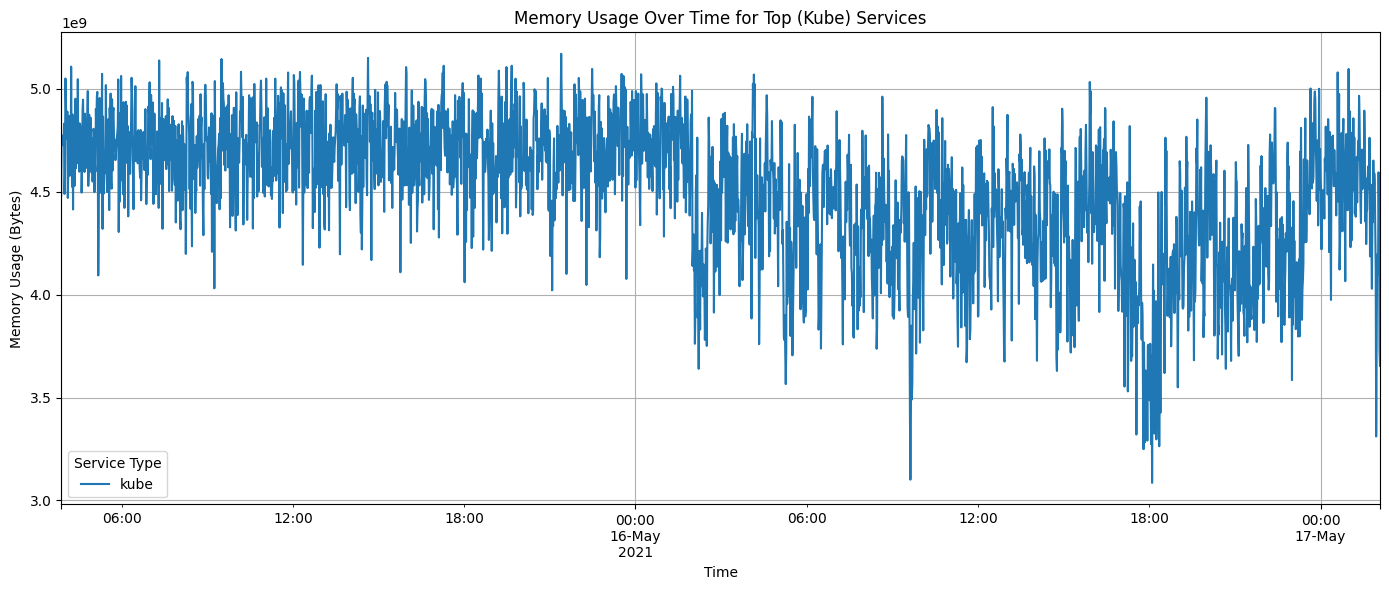

In [18]:
# Pivot for plotting
pivoted = grouped.pivot(index='Time', columns='service_type', values='memory_usage_max')

# Plot
plt.figure(figsize=(14, 6))
pivoted.plot(ax=plt.gca())
plt.title('Memory Usage Over Time for Top (Kube) Services')
plt.ylabel('Memory Usage (Bytes)')
plt.xlabel('Time')
plt.grid(True)
plt.legend(title='Service Type')
plt.tight_layout()
plt.show()


In [16]:
# Step 1: Filter for the top memory-consuming services
top_services = ['kube', 'etcd', 'jaeger']
filtered_df = merged_full[
    merged_full['service_type'].isin(top_services)
][['service_type', 'EventTemplate', 'ParameterList', 'memory_usage_raw', 'memory_usage_max', 'log_count']]


In [17]:
# Define a threshold (e.g., 90th percentile)
threshold = filtered_df['memory_usage_max'].quantile(0.9)

# Subset where memory usage is high
high_mem_df = filtered_df[filtered_df['memory_usage_max'] > threshold]

# Most common templates
top_templates = high_mem_df['EventTemplate'].value_counts().head(10)
print(top_templates)
# Most common parameter patterns
top_params = high_mem_df['ParameterList'].value_counts().head(10)
print(top_params)

EventTemplate
Span written to the storage by the collector                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      2694431
Zipkin span batch processed by the collector.                                                                                                                                                                                                                                                   

## Insights from High-Memory Logs
### Most Frequent EventTemplates during High Memory Usage:

    - Span written to the storage by the collector → 3.15 million times: Likely related to jaeger, intense tracing/logging activity.

    - Zipkin span batch processed by the collector. → ~657k times: More batch processing by trace collector.

    - Several gRPC/internal Kubernetes messages suggest internal orchestration load.

Kubernetes Errors:

    - FieldManager error (failed to update managedFields) → ~40k times: may suggest frequent write/update operations under load (etcd/kube).

Syncing Secrets/ConfigMaps (Kube):

    - Secrets and configmaps synced repeatedly → ~34k times each: expected under heavy dynamic workloads (pods, services being created/destroyed).

### Top ParameterList Entries

    - Most are empty ([]) → ~4 million times.

    - Some have URLs (https://192.168...) → These are etcd API calls.

    - A few with states like '{CONNECTING', '{READY' → gRPC connection transitions (jaeger, etcd).

SVM on TF-iDF EventTemplate and max_memory

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
template_agg = (
    filtered_df
    .groupby("EventTemplate")
    .agg({
        "memory_usage_max": "mean",
        "log_count": "sum"
    })
    .reset_index()
)

# Label: templates with high average memory usage
threshold = template_agg['memory_usage_max'].quantile(0.90)
template_agg['high_memory'] = (template_agg['memory_usage_max'] > threshold).astype(int)


In [20]:
template_agg

,EventTemplate,memory_usage_max,log_count,high_memory
0,"""Deleting object"" <*> <*> kind=""Pod"" propagati...",3.588025e+09,31528,0
1,"""Event occurred"" <*> <*> <*> type=""Normal"" rea...",4.380685e+09,25596,0
2,"""Event occurred"" <*> kind=""CronJob"" apiVersion...",4.056937e+09,57176,0
3,"""Event occurred"" <*> kind=""CronJob"" apiVersion...",3.532577e+09,31618,0
4,"""Event occurred"" <*> kind=""Job"" apiVersion=""ba...",3.360293e+09,11682,0
...,...,...,...,...
1837,retrying of unary invoker failed,8.242110e+08,6628,0
1838,syncing external loadbalancer hostnames: api.l...,4.417301e+09,4687,0
1839,syncing servicenetwork hostnames: [172.30.0.1 ...,4.417301e+09,4687,0
1840,transport: loopyWriter.run returning. connecti...,4.825583e+09,664947,0


In [21]:
# === Step 4: TF-IDF vectorization of EventTemplate ===
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
# Vectorize
X_tfidf = tfidf.fit_transform(template_agg['EventTemplate'])

In [22]:
# === Step 5: Dimensionality reduction ===
from sklearn.decomposition import TruncatedSVD

# Apply SVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

print("SVD shape:", X_reduced.shape)

SVD shape: (1842, 50)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, template_agg["high_memory"], test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.64      0.76       328
           1       0.16      0.56      0.25        41

    accuracy                           0.63       369
   macro avg       0.54      0.60      0.51       369
weighted avg       0.84      0.63      0.70       369

[[211 117]
 [ 18  23]]


In [26]:
feature_weights = clf.coef_[0]
top_features = sorted(
    zip(tfidf.get_feature_names_out(), feature_weights),
    key=lambda x: abs(x[1]),
    reverse=True
)[:20]

for term, weight in top_features:
    print(f"{term}: {weight:.3f}")


003396641s: 3.794
098729ms: -2.711
099663ms: -2.584
09893ms: -2.433
092351704s: 2.142
00: 2.006
100728ms: -1.670
07: 1.655
05: -1.615
096858041s: 1.602
09338442s: 1.473
009054ms: 1.397
006051103s: 1.363
096967ms: 1.262
008469ms: -1.157
093084702s: -1.122
09329ms: -0.940
098893ms: 0.731
096147436s: -0.731
003368227s: 0.724


## Merged full dataset

In [7]:
merged_df = pd.read_parquet(logs_path / "merged_df.parquet")
merged_df

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage,memory_usage
0,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0
1,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0
2,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0
3,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0
4,2021-05-15 03:55:39,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:55:39.875Z|104013|reconnect|WA...,0.004093,37638144.0
...,...,...,...,...,...,...,...
77888954,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{CONNECTING'],0.006671,262672384.0
77888955,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Channel', 'CONNECTING']",0.006671,262672384.0
77888956,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Subchannel', 'READY']",0.006671,262672384.0
77888957,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{READY'],0.006671,262672384.0


In [9]:
merged_df = merged_df.rename(columns={
    'cpu_usage': 'cpu_usage_raw',
    'memory_usage': 'memory_usage_raw'
})
merged_df

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw
0,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0
1,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0
2,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0
3,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0
4,2021-05-15 03:55:39,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:55:39.875Z|104013|reconnect|WA...,0.004093,37638144.0
...,...,...,...,...,...,...,...
77888954,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{CONNECTING'],0.006671,262672384.0
77888955,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Channel', 'CONNECTING']",0.006671,262672384.0
77888956,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Subchannel', 'READY']",0.006671,262672384.0
77888957,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{READY'],0.006671,262672384.0


In [10]:
# Merge the detailed logs with the aggregated metrics
merged_full = pd.merge(
    merged_df,
    grouped_df,
    how='inner',
    on=['service_type', 'Time']
)

In [11]:
output_file = logs_path / "merged_full.parquet"
merged_full.to_parquet(output_file, index=False)

In [4]:
merged_full = pd.read_parquet(logs_path / "merged_full.parquet")
merged_full

,Time,service_type,EventTemplate,EventId,ParameterList,cpu_usage_raw,memory_usage_raw,cpu_usage_max,memory_usage_max,log_count
0,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0,0.004108,37638144.0,4
1,2021-05-15 03:54:01,ovs,<*> send error: Broken pipe,54,['2021-05-15T03:54:01.656Z|104010|jsonrpc|WARN...,0.004108,37638144.0,0.004108,37638144.0,4
2,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0,0.004108,37638144.0,4
3,2021-05-15 03:54:01,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:54:01.656Z|104011|reconnect|WA...,0.004108,37638144.0,0.004108,37638144.0,4
4,2021-05-15 03:55:39,ovs,<*> connection dropped (Broken pipe),55,['2021-05-15T03:55:39.875Z|104013|reconnect|WA...,0.004093,37638144.0,0.004093,37638144.0,4
...,...,...,...,...,...,...,...,...,...,...
77888954,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{CONNECTING'],0.006671,262672384.0,0.006671,262672384.0,8
77888955,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Channel', 'CONNECTING']",0.006671,262672384.0,0.006671,262672384.0,8
77888956,2021-05-17 01:36:16,mongodb,info <*> Connectivity change to <*>,46,"['Subchannel', 'READY']",0.006671,262672384.0,0.006671,262672384.0,8
77888957,2021-05-17 01:36:16,mongodb,info pickfirstBalancer: HandleSubConnStateChan...,48,['{READY'],0.006671,262672384.0,0.006671,262672384.0,8


In [9]:
print(merged_full.columns)
print(merged_full.shape)

Index(['Time', 'service_type', 'EventTemplate', 'EventId', 'ParameterList',
       'cpu_usage_raw', 'memory_usage_raw', 'cpu_usage_max',
       'memory_usage_max', 'log_count'],
      dtype='object')
(77888959, 10)


In [12]:
merged_full.info()
merged_full.describe()
merged_full['service_type'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77888959 entries, 0 to 77888958
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Time              object 
 1   service_type      object 
 2   EventTemplate     object 
 3   EventId           int64  
 4   ParameterList     object 
 5   cpu_usage_raw     float64
 6   memory_usage_raw  float64
 7   cpu_usage_max     float64
 8   memory_usage_max  float64
 9   log_count         int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 5.8+ GB


service_type
jaeger            40258240
productpage       21927987
details            8438320
cluster            2216337
openshift          1404496
kube               1112350
ratings             599010
apiserver           479123
etcd                423559
packageserver       204004
ovs                 145116
my                  133644
cloud                83817
network              77551
downloads            66550
olm                  40216
kafka                34121
machine              32746
dispatch             29355
catalog              28146
service              27890
diskmaker            21606
insights             21125
istiod               12708
authentication       10640
marketplace          10445
sdn                   7410
reviews               6930
csi                   6802
prometheus            5623
amq                   4158
user                  3662
cart                  3644
catalogue             3613
local                  975
mongodb                856
web            

In [14]:
# Top templates
merged_full['EventTemplate'].value_counts().head(10)

# Diversity of templates per service
template_diversity = merged_full.groupby('service_type')['EventTemplate'].nunique().sort_values(ascending=False)
print(template_diversity.head(10))

service_type
kube          1782
reviews        277
etcd            59
cluster         52
apiserver       32
machine         27
network         26
my              23
insights        22
prometheus      18
Name: EventTemplate, dtype: int64
